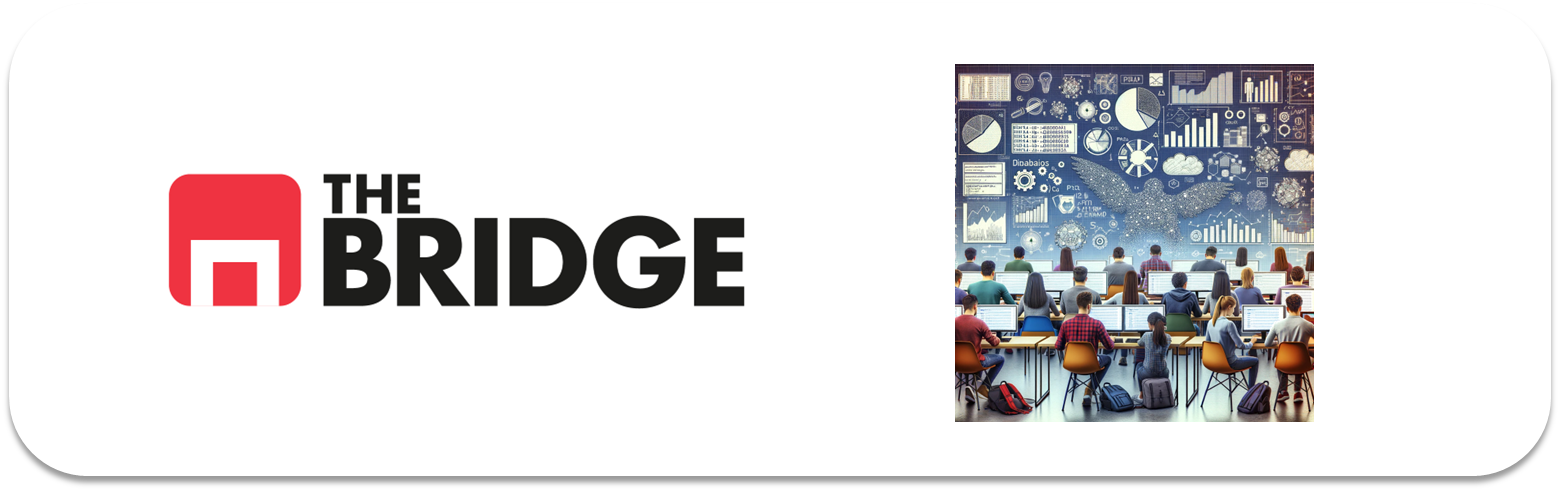

## PRACTICA OBLIGATORIA: **Clasificacion y Regresion Logistica**

* La práctica obligatoria de esta unidad consiste en modelar la supervivencia en el Titanic, por fin, además de una parte adicional multiclase. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from pprint import pprint
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Cargar el dataset del Titanic
df = pd.read_csv("./data/titanic.csv")

### Indicaciones

A continuación tienes las indicaciones para hacer el modelado. No necesariamente tienes que seguirlos al pie de la letra, porque a partir de ahora ya las práctica obligatorias dejarán de ser mayormente guiadas por ejercicios y serán más de libre desarrollo, aunque con objetivos específicos, claros y determinados. 

En concreto se pide hacer un modelo de regresión logística, evaluarlo contra un dataset de test reservado del original mostrando las métricas propias de los problemas de clasificación, la matriz de confusión y la curva ROC. Además se pide comparar las predicciones con los valores reales y al final adaptar el modelo a un problema multiclase.

Los pasos para guiar el trabajo:
1. Carga el dataset del Titanic. 
2. Deshazte de las variables que no vayas a usar. Limpia lo que creas necesarios pero no hagas imputaciones.
3. Escoge y analiza la variable target de forma gráfica y razona sobre el impacto de la distribución en los resultados esperados. Ten en cuenta que lo que queremos es poder predecir si un pasajero sobrevivirá.
4. Haz el split en train y test que creas conveniente pero asegurándote que ambos conjuntos tienen un reparto similar de pasajeros embarcados en las tres ciudades.
5. Construye las parejas X,y de train y test.
6. Ahora sí imputa los nulos con medias y modas en la X de train. Guarda esas medias que necesitarás en la parte de test.
7. Haz un mini-EDA, selecciona las features que quieres quedarte y por qué.
8. Trata las variables para que funcionen lo mejor posible en el modelo.
9. Construye un modelo de regresión logística.
10. EXTRA: Analiza si lo crees conveniente los pesos y la importancia de las features.
11. Procesa el dataset de Test para que puedas usarlo en la evaluación 
12. Evalúa tu modelo contra el dataset de test y train. Obten las matrices de confusión y las métricas que creas adecuadas. Haz un pequeño assesment de su generabilidad.
13. EXTRA: Halla la probabilidad de supervivencia de un hombre de entre 30 y 40 años, que embarcó en Southampton en segunda clase, viajaba solo y no pagó el billete. PISTA: En este caso tendrás que calcular varias probabilidades y hacer la media de ellas.
14. EXTRA: Aprovecha todo el trabajo haciendo un único cambio en el target, ahora será la clase del viajero. Cambia el target quitándolo de X_train, X_test y añade a estos el target anterior. El resto no deberías cambiarlo. Entrena y evalua el modelo sólo con el classification_report.  



### Preparación Datos: Primer Vistazo

In [87]:
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


### Preparación Datos: Limpieza de datos

In [88]:
df.rename(columns = {'survived': 'target'}, inplace=True)

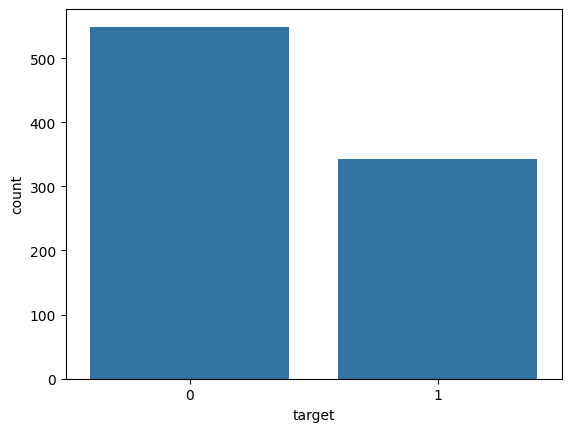

In [89]:
sns.countplot(data=df, x='target');

In [90]:
df.isnull().sum()

target           0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [91]:
# Eliminar variables que no vamos a usar
df.drop(['deck'], axis=1, inplace=True)

# Limpieza básica: eliminar filas con valores nulos en 'Embarked'
df.dropna(subset=['age','embarked'], inplace=True)

In [92]:
# Primero, selecciona las características numéricas
numeric_features = df.select_dtypes(include=['float64', 'int64'])

# Luego, selecciona las características categóricas que quieres codificar
categorical_features = df.select_dtypes(include=['object'])

# Codifica las características categóricas usando One-Hot Encoding
encoded_categorical_features = pd.get_dummies(categorical_features)

# Combina las características numéricas y las codificadas
df = pd.concat([numeric_features, encoded_categorical_features], axis=1)



In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 0 to 890
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   target                   712 non-null    int64  
 1   pclass                   712 non-null    int64  
 2   age                      712 non-null    float64
 3   sibsp                    712 non-null    int64  
 4   parch                    712 non-null    int64  
 5   fare                     712 non-null    float64
 6   sex_female               712 non-null    bool   
 7   sex_male                 712 non-null    bool   
 8   embarked_C               712 non-null    bool   
 9   embarked_Q               712 non-null    bool   
 10  embarked_S               712 non-null    bool   
 11  class_First              712 non-null    bool   
 12  class_Second             712 non-null    bool   
 13  class_Third              712 non-null    bool   
 14  who_child                712 no

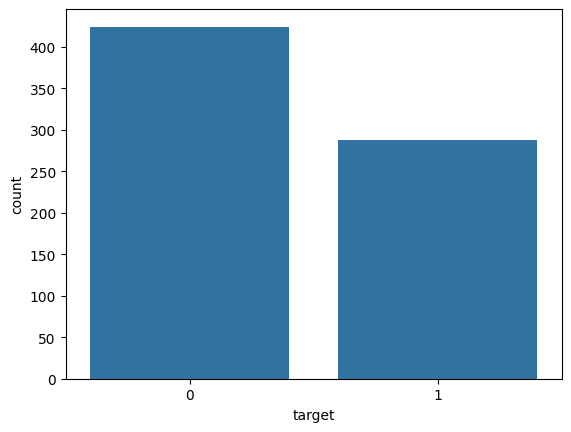

In [94]:
sns.countplot(data=df, x='target');

### Preparación datos: Dividimos el dataset

In [95]:

X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42) 

### MiniEDA: Matriz de correlación

In [96]:
df_eda = X_train.copy()
df_eda["target"] = y_train.copy()

In [97]:
np.abs(df_eda.corr()['target']).sort_values(ascending=False)

alive_no                   1.000000
target                     1.000000
alive_yes                  1.000000
who_man                    0.559418
sex_male                   0.550454
sex_female                 0.550454
who_woman                  0.516410
pclass                     0.372225
class_Third                0.348755
class_First                0.310660
fare                       0.274734
embarked_C                 0.173712
embark_town_Cherbourg      0.173712
embarked_S                 0.152835
embark_town_Southampton    0.152835
who_child                  0.120932
parch                      0.105276
class_Second               0.090109
age                        0.073064
embarked_Q                 0.022955
embark_town_Queenstown     0.022955
sibsp                      0.005642
Name: target, dtype: float64

In [98]:
corr = np.abs(df_eda.corr()['target']).sort_values(ascending=False)

# Features con menos de 0.1 de correlación vs el target
bad_corr_feat = corr[corr < 0.05].index.values

# Filtramos las columnas buenas
df_eda.drop(columns=bad_corr_feat, inplace=True)

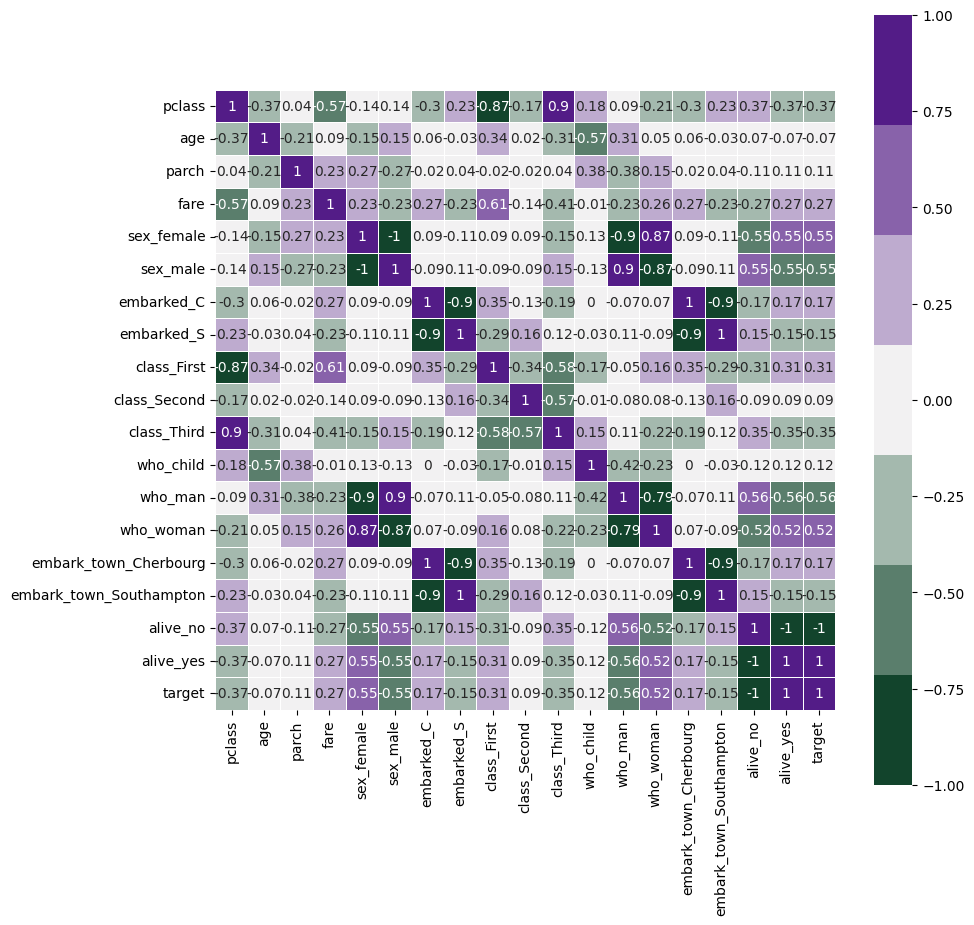

In [99]:
plt.figure(figsize=(10,10))
sns.heatmap(np.round(df_eda.corr(), 2),
            vmin=-1,
            vmax=1,
            annot=True,
            cmap=sns.diverging_palette(145, 280, s=85, l=25, n=7),
            square=True,
            linewidths=.5);

In [100]:
features_num = [col for col in df_eda.columns if "target" not in col]
X_train = X_train[features_num].copy()

### Preparación de Features

array([[<Axes: title={'center': 'pclass'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'parch'}>,
        <Axes: title={'center': 'fare'}>]], dtype=object)

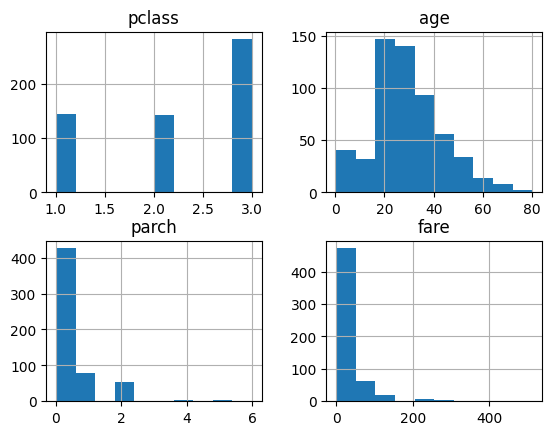

In [101]:
X_train.hist()

In [102]:
X_train.describe()

,pclass,age,parch,fare
count,569.000000,569.000000,569.000000,569.000000
mean,2.240773,29.582021,0.405975,32.053566
std,0.832879,14.194751,0.842552,46.621635
min,1.000000,0.420000,0.000000,0.000000
25%,1.000000,21.000000,0.000000,8.050000
50%,2.000000,28.000000,0.000000,14.458300
75%,3.000000,38.000000,1.000000,31.000000
max,3.000000,80.000000,6.000000,512.329200


In [103]:
X_train[X_train["fare"] > 0]

,pclass,age,parch,fare,sex_female,sex_male,embarked_C,embarked_S,class_First,class_Second,class_Third,who_child,who_man,who_woman,embark_town_Cherbourg,embark_town_Southampton,alive_no,alive_yes
472,2,33.0,2,27.7500,True,False,False,True,False,True,False,False,False,True,False,True,False,True
432,2,42.0,0,26.0000,True,False,False,True,False,True,False,False,False,True,False,True,False,True
666,2,25.0,0,13.0000,False,True,False,True,False,True,False,False,True,False,False,True,True,False
30,1,40.0,0,27.7208,False,True,True,False,True,False,False,False,True,False,True,False,True,False
291,1,19.0,0,91.0792,True,False,True,False,True,False,False,False,False,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,3,26.0,2,20.5750,False,True,False,True,False,False,True,False,True,False,False,True,True,False
135,2,23.0,0,15.0458,False,True,True,False,False,True,False,False,True,False,True,False,True,False
338,3,45.0,0,8.0500,False,True,False,True,False,False,True,False,True,False,False,True,False,True
549,2,8.0,1,36.7500,False,True,False,True,False,True,False,True,False,False,False,True,False,True


### Modelo

In [104]:
log_reg = LogisticRegression(max_iter = 5000)

log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [105]:
print(log_reg.coef_)
print(log_reg.intercept_)
print(log_reg.classes_)

[[-3.41711267e-01 -1.13898006e-02 -9.04463386e-02  1.13331548e-03
   3.03789346e-01 -2.93433421e-01  6.87175346e-02  1.92791999e-03
   1.84529300e-01  3.72044017e-03 -1.77893816e-01  1.19665508e-01
  -4.13942664e-01  3.04633080e-01  6.87175346e-02  1.92791999e-03
  -3.91338066e+00  3.92373659e+00]]
[1.05253844]
[0 1]


### Feature importance

In [106]:
intercept = log_reg.intercept_
coefs = log_reg.coef_.ravel()

features = pd.DataFrame(coefs, X_train.columns, columns=['coefficient']).copy()
features['coefficient'] = np.abs(features['coefficient'])

features.sort_values('coefficient', ascending=False).head()

,coefficient
alive_yes,3.923737
alive_no,3.913381
who_man,0.413943
pclass,0.341711
who_woman,0.304633


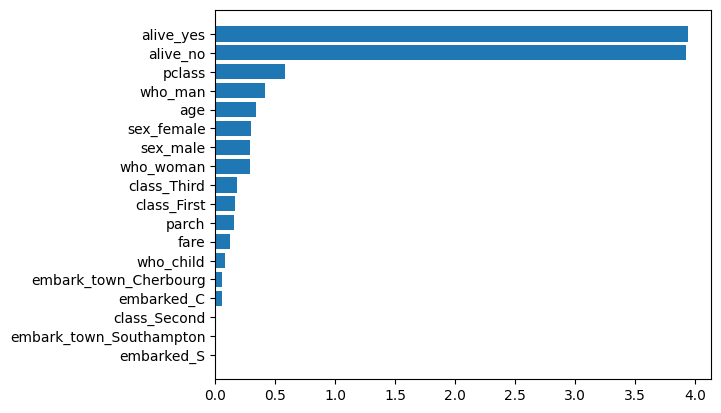

In [107]:
stdevs = []
for i in X_train.columns:
    stdev = df[i].std()
    stdevs.append(stdev)

features["stdev"] = np.array(stdevs).reshape(-1,1)
features["importance"] = features["coefficient"] * features["stdev"]
features['importance_standarized'] = features['importance'] / y_train.std()

features = features.sort_values('importance_standarized', ascending=True)
plt.barh(features.index, features.importance_standarized);

## Accuracy

Antes de usar el X_test hay que hacerles las mismas transformaciones que le hayamos hecho al X_train

In [108]:
X_test = X_test[X_train.columns].copy()

In [109]:
acc_train = round(accuracy_score(log_reg.predict(X_train), y_train), 3)
acc_test = round(accuracy_score(log_reg.predict(X_test), y_test), 3)

print("Accuracy train:", acc_train)
print("Accuracy test:", acc_test)

Accuracy train: 1.0
Accuracy test: 1.0


¿Es buenos nuestro clasificador?

In [110]:
y_train.value_counts(True)

target
0    0.604569
1    0.395431
Name: proportion, dtype: float64

In [111]:
y_test.value_counts(True)

target
0    0.559441
1    0.440559
Name: proportion, dtype: float64

Parece que es bueno, bastante equilibrado.

### Confusion matrix

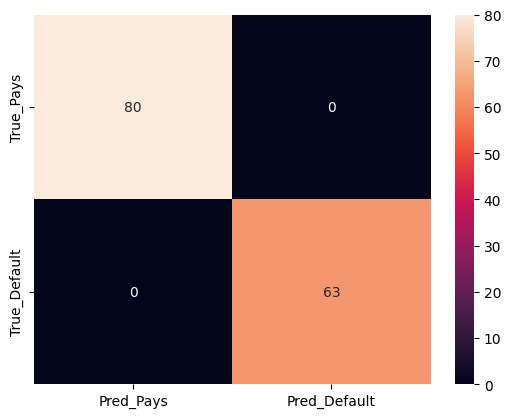

In [112]:

c_matrix = confusion_matrix(y_test, log_reg.predict(X_test))

c_matrix_df = pd.DataFrame(c_matrix, columns = ['Pred_Pays', 'Pred_Default'],
                          index = ['True_Pays', 'True_Default'])

sns.heatmap(c_matrix_df, annot=True, fmt='g');

c:\Users\buque\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


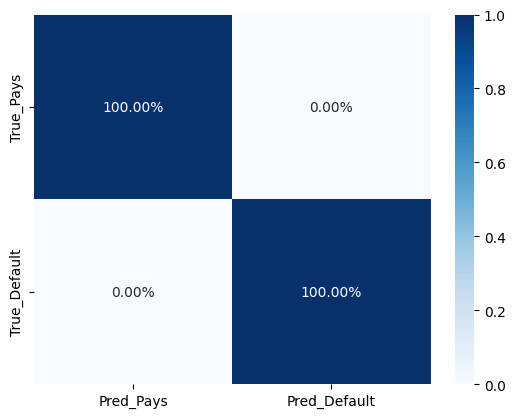

In [113]:
sns.heatmap(c_matrix_df/np.sum(c_matrix_df), annot=True, 
            fmt='.2%', cmap='Blues');

## Classification report

In [114]:

print(classification_report(y_test, log_reg.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      1.00      1.00        63

    accuracy                           1.00       143
   macro avg       1.00      1.00      1.00       143
weighted avg       1.00      1.00      1.00       143



## ROC Curve

AUROC: 1.00


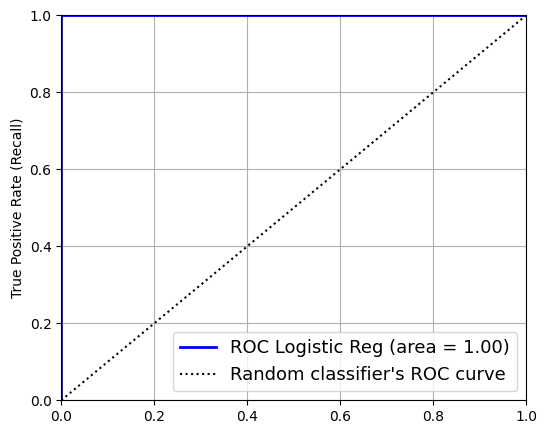

In [115]:
### Usando matplotlib

scores = log_reg.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, scores[:,1])
roc_auc = auc(fpr,tpr)
print("AUROC: %.2f" %(roc_auc))
plt.figure(figsize=(6, 5))  
plt.plot(fpr, tpr, linewidth=2, color= "blue", label=f"ROC Logistic Reg (area = {roc_auc:0.2f})")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)